In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from sklearn.model_selection import train_test_split

In [2]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, no_of_patches, hidden_size):
        super(PatchEncoder, self).__init__(name= "patch_encoder")
        self.no_of_patches=no_of_patches
        self.linear_projection= tf.keras.layers.Dense(hidden_size)
        self.positonal_embedding= tf.keras.layers.Embedding(no_of_patches,hidden_size)
    
    def call(self, img):
        patches=tf.image.extract_patches(images=img,
                                 sizes=[1,16,16,1],
                                 strides=[1,16,16,1],
                                 rates=[1,1,1,1],
                                 padding='VALID')
                                 
        patches=tf.reshape(patches,(tf.shape(patches)[0],-1,patches.shape[-1]))
        embedding_input=tf.range(0,self.no_of_patches,1)
        ans=self.linear_projection(patches)+self.positonal_embedding(embedding_input)
        return ans

In [3]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, no_of_heads, hidden_size):
        super(TransformerEncoder, self).__init__(name= "transformer_encoder")
        self.layer_norm= tf.keras.layers.LayerNormalization()
        self.multi_head_attention=tf.keras.layers.MultiHeadAttention(no_of_heads,hidden_size)
        self.denselayer=tf.keras.layers.Dense(hidden_size, activation='gelu')
    
    def call(self, img):
        x_1=self.layer_norm(img)
        x_1=self.multi_head_attention(x_1,x_1)
        x_1=tf.keras.layers.Add()([x_1,img])

        x_2=self.layer_norm(x_1)
        x_2=self.denselayer(x_2)
        ans=self.denselayer(x_2)
        ans=tf.keras.layers.Add()([ans,x_1])

        return ans

In [4]:
class VisT(tf.keras.Model):
    def __init__(self, no_of_heads, hidden_size, no_of_patches, no_of_layers,no_of_dense_units):
        super(VisT,self).__init__(name= 'vision_transformer')
        self.no_of_layers=no_of_layers
        self.patch_encoder=PatchEncoder(no_of_patches,hidden_size)
        self.transformer_encoder=[TransformerEncoder(no_of_heads, hidden_size) for _ in range(no_of_layers)]
        self.densel=tf.keras.layers.Dense(no_of_dense_units, "gelu")
        self.densel2=tf.keras.layers.Dense(64, "gelu")
        self.densel3=tf.keras.layers.Dense(32, "gelu")
        self.denselO=tf.keras.layers.Dense(10, "softmax")
    
    def call(self, data, training=True):
        if isinstance(data, tuple):
            img, _ = data  # Extract only the images from the generator output
        else:
            img = data

        # Ensure the correct shape of the input tensor
        img = tf.image.resize(img, (256, 256))  # Resize the image to match the expected size
        img = tf.reshape(img, (tf.shape(img)[0], 256, 256, 3))  # Explicitly reshape to (batch_size, height, width, channels)

        inp = self.patch_encoder(img)

        for i in range(self.no_of_layers):
            inp = self.transformer_encoder[i](inp)

        inp = tf.keras.layers.Flatten()(inp)
        inp = self.densel(inp)
        inp = self.densel2(inp)
        inp = self.densel3(inp)
        return self.denselO(inp)

In [17]:
path = 'test_Minor'
size = [256, 256]
classes = ['Alluvial Soil', 'Black Soil', 'Clay Soil',"Red Soil"]

In [36]:
all_images = []
all_labels = []

for class_index, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        all_images.append(img_path)
        all_labels.append(class_index)

In [37]:
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.5, random_state=12
)

In [38]:
datagen_training_augmentation = ImageDataGenerator(
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=60
)

In [39]:
augmented_images = []
augmented_labels = []

for i in range(5):  
    for img_path, label in zip(train_images, train_labels):
        rotation_angle = np.random.uniform(-60, 60)  
        img = load_img(img_path, target_size=size)
        img_array = img_to_array(img)
        img_array = datagen_training_augmentation.apply_transform(img_array, {'theta': rotation_angle})
        augmented_images.append(img_array)
        augmented_labels.append(label)
    print("W",i)

W 0
W 1
W 2
W 3
W 4


In [40]:
train_images1 = np.array(augmented_images[0:int(len(augmented_images)*0.35)])
train_labels1 = np.array(augmented_labels[0:int(len(augmented_images)*0.35)])
augmented_images=augmented_images[int(len(augmented_images)*0.35):]
augmented_labels=augmented_labels[int(len(augmented_labels)*0.35):]
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [41]:
train_images2, valid_images, train_labels2, valid_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.47, random_state=42
)

In [42]:
del augmented_images
del augmented_labels

In [43]:
valid_images1, valid_images2, valid_labels1, valid_labels2=train_test_split(
    valid_images, valid_labels, test_size=0.5, random_state=42
)

In [44]:
vit = VisT(2, 256, 256, 2, 64)
vit.compile(optimizer="Adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [45]:
epochs=20
trainig_history=[]
for epoch in range(epochs):
    print("Epoch",epoch+1,"/",epochs,"------->")
    if epoch % 2 == 0:
        # Using the first half of the dataset in even epochs
        data = train_images1
        labels = train_labels1
        vdata = valid_images1
        vlabel = valid_labels1
    else:
        # Using the second half of the dataset in odd epochs
        data = train_images2
        labels = train_labels2
        vdata = valid_images2
        vlabel = valid_labels2

    # Training the model using the selected half of the dataset
    h=vit.fit(data, labels, batch_size=32, epochs=1, validation_data=(vdata, vlabel))
    trainig_history.append(h)

Epoch 1 / 20 ------->
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.0837 - loss: 785.8535 - val_accuracy: 0.5039 - val_loss: 385.6119
Epoch 2 / 20 ------->
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3874 - loss: 456.3470 - val_accuracy: 0.4567 - val_loss: 891.2032
Epoch 3 / 20 ------->
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 894ms/step - accuracy: 0.3438 - loss: 584.3327 - val_accuracy: 0.3465 - val_loss: 501.2964
Epoch 4 / 20 ------->
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 981ms/step - accuracy: 0.2962 - loss: 990.0624 - val_accuracy: 0.5748 - val_loss: 310.0756
Epoch 5 / 20 ------->
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.4286 - loss: 602.5257 - val_accuracy: 0.4724 - val_loss: 295.0963
Epoch 6 / 20 ------->
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 995ms/step - accuracy: 0.5157 - loss: 249.2988 - val_accuracy: 0.3543 - val_loss: 362.8998
Epoch 7 / 20 ------->
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.5157 - loss: 262.6604 - val_accuracy: 0.7008 - val_loss: 80.1731
Epoch 8 / 2

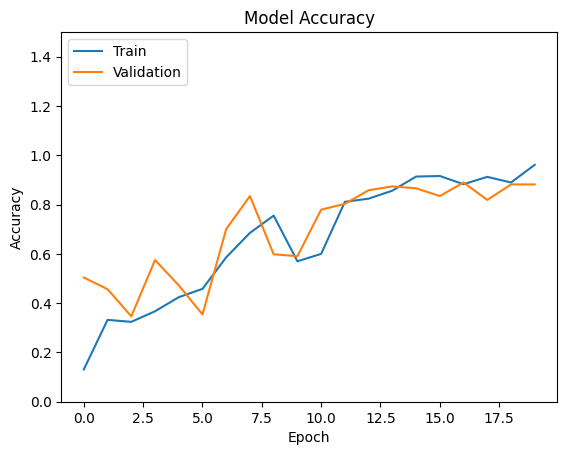

In [46]:
import matplotlib.pyplot as plt
accu=[x.history['accuracy'] for x in trainig_history]
val_accu=[x.history['val_accuracy'] for x in trainig_history]
plt.plot(accu)
plt.plot(val_accu)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.ylim(0,1.5)
plt.show()

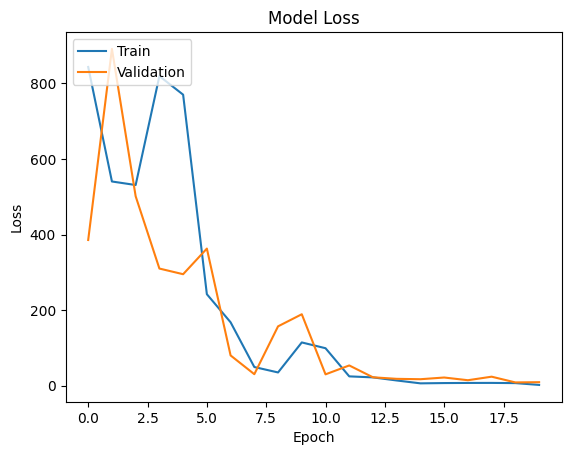

In [47]:
loss=[x.history['loss'] for x in trainig_history]
val_loss=[x.history['val_loss'] for x in trainig_history]
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [48]:
processed_test_images = []
for img_path in test_images:
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    processed_test_images.append(img_array)

processed_test_images = np.array(processed_test_images)
vit.evaluate(processed_test_images, np.array(test_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.7371 - loss: 19.1414


[20.345687866210938, 0.7349397540092468]

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report

processed_test_images = np.array(processed_test_images)
predictions = np.argmax(vit.predict(processed_test_images), axis=1)

# Display classification report
class_report = classification_report(test_labels, predictions, target_names=classes)
print(class_report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
               precision    recall  f1-score   support

Alluvial Soil       0.23      0.18      0.20        28
   Black Soil       0.92      0.87      0.89        52
    Clay Soil       0.52      0.52      0.52        25
     Red Soil       0.84      0.97      0.90        61

     accuracy                           0.73       166
    macro avg       0.63      0.63      0.63       166
 weighted avg       0.71      0.73      0.72       166



In [50]:
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate class-wise accuracy
class_wise_accuracy = {}
for i in range(len(classes)):
    class_accuracy =  np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    class_accuracy= 1 - (class_accuracy/np.sum(conf_matrix[:, :]))*4
    class_wise_accuracy[classes[i]] = class_accuracy
    print(f"Accuracy for class {classes[i]}: {class_accuracy:.2%}")

# Overall accuracy
overall_accuracy = accuracy_score(test_labels, predictions)
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")

Confusion Matrix:
[[ 5  3 12  8]
 [ 7 45  0  0]
 [ 8  1 13  3]
 [ 2  0  0 59]]
Accuracy for class Alluvial Soil: 44.58%
Accuracy for class Black Soil: 83.13%
Accuracy for class Clay Soil: 71.08%
Accuracy for class Red Soil: 95.18%

Overall Accuracy: 73.49%
